<a href="https://colab.research.google.com/github/SujithSaiSripadam/FaceDetection/blob/main/vivit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq medmnist

In [ ]:
import os
import io
import imageio
import medmnist
import ipywidgets
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Setting seed for reproducibility
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
keras.utils.set_random_seed(SEED)

In [ ]:
# DATA
DATASET_NAME = "organmnist3d"
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (28, 28, 28, 1)
NUM_CLASSES = 11

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 2

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 8

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
def download_and_prepare_dataset(data_info: dict):
    """Utility function to download the dataset.

    Arguments:
        data_info (dict): Dataset metadata.
    """
    data_path = keras.utils.get_file(origin=data_info["url"], md5_hash=data_info["MD5"])

    with np.load(data_path) as data:
        # Get videos
        train_videos = data["train_images"]
        valid_videos = data["val_images"]
        test_videos = data["test_images"]

        # Get labels
        train_labels = data["train_labels"].flatten()
        valid_labels = data["val_labels"].flatten()
        test_labels = data["test_labels"].flatten()

    return (
        (train_videos, train_labels),
        (valid_videos, valid_labels),
        (test_videos, test_labels),
    )


# Get the metadata of the dataset
info = medmnist.INFO[DATASET_NAME]

# Get the dataset
prepared_dataset = download_and_prepare_dataset(info)
(train_videos, train_labels) = prepared_dataset[0]
(valid_videos, valid_labels) = prepared_dataset[1]
(test_videos, test_labels) = prepared_dataset[2]

In [ ]:
@tf.function
def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels."""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )
    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label


def prepare_dataloader(
    videos: np.ndarray,
    labels: np.ndarray,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare the dataloader."""
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    return dataloader

trainloader = prepare_dataloader(train_videos, train_labels, "train")
validloader = prepare_dataloader(valid_videos, valid_labels, "valid")
testloader = prepare_dataloader(test_videos, test_labels, "test")

Tubelet Embedding
In ViTs, an image is divided into patches, which are then spatially flattened, a process known as tokenization. For a video, one can repeat this process for individual frames. Uniform frame sampling as suggested by the authors is a tokenization scheme in which we sample frames from the video clip and perform simple ViT tokenization.


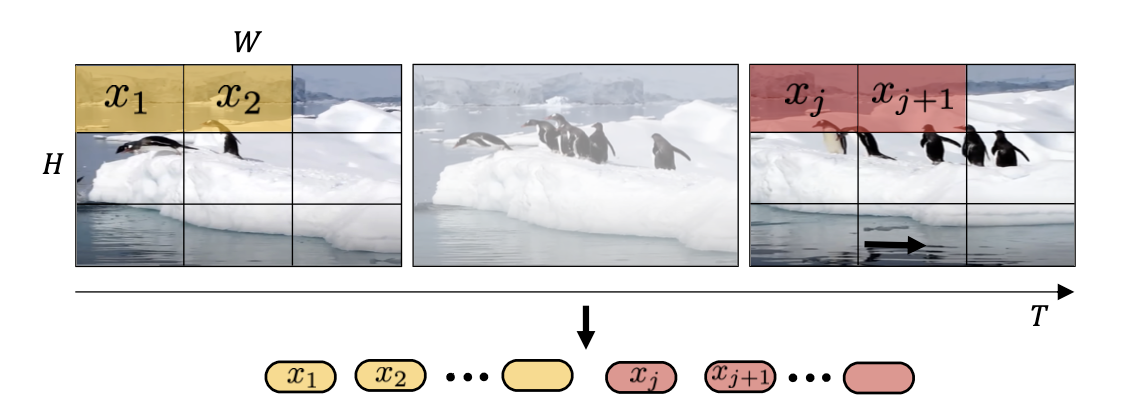

Tubelet Embedding is different in terms of capturing temporal information from the video. First, we extract volumes from the video -- these volumes contain patches of the frame and the temporal information as well. The volumes are then flattened to build video tokens.

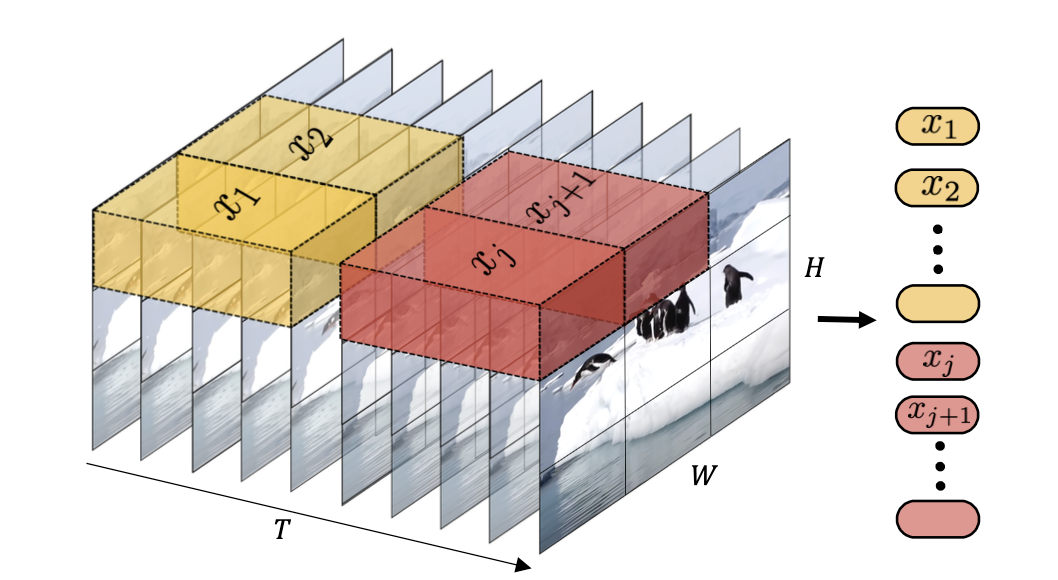

In [ ]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

In [ ]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

In [ ]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def run_experiment():
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
    )

    # Compile the model with the optimizer, loss function
    # and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Train the model.
    _ = model.fit(trainloader, epochs=EPOCHS, validation_data=validloader)

    _, accuracy, top_5_accuracy = model.evaluate(testloader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model


model = run_experiment()

Epoch 1/2
31/31 [==============================] - 236s 7s/step - loss: 2.5485 - accuracy: 0.1111 - top-5-accuracy: 0.5597 - val_loss: 2.3513 - val_accuracy: 0.1988 - val_top-5-accuracy: 0.5776
Epoch 2/2
20/20 [==============================] - 1s 70ms/step - loss: 2.1682 - accuracy: 0.2246 - top-5-accuracy: 0.7246
Test accuracy: 22.46%
Test top 5 accuracy: 72.46%


In [ ]:
NUM_SAMPLES_VIZ = 25
testsamples, labels = next(iter(testloader))
testsamples, labels = testsamples[:NUM_SAMPLES_VIZ], labels[:NUM_SAMPLES_VIZ]

ground_truths = []
preds = []
videos = []

for i, (testsample, label) in enumerate(zip(testsamples, labels)):
    # Generate gif
    with io.BytesIO() as gif:
        #imageio.mimsave(gif, (testsample.numpy() * 255).astype("uint8"), "GIF", duration=5)
        imageio.mimsave(gif, testsample.numpy().squeeze(), "GIF", duration=5)

        videos.append(gif.getvalue())

    # Get model prediction
    output = model.predict(tf.expand_dims(testsample, axis=0))[0]
    pred = np.argmax(output, axis=0)

    ground_truths.append(label.numpy().astype("int"))
    preds.append(pred)
    print(preds)

def make_box_for_grid(image_widget, fit):
    """Make a VBox to hold caption/image for demonstrating option_fit values.

    Source: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
    """
    # Make the caption
    if fit is not None:
        fit_str = "'{}'".format(fit)
    else:
        fit_str = str(fit)

    h = ipywidgets.HTML(value="" + str(fit_str) + "")

    # Make the green box with the image widget inside it
    boxb = ipywidgets.widgets.Box()
    boxb.children = [image_widget]

    # Compose into a vertical box
    vb = ipywidgets.widgets.VBox()
    vb.layout.align_items = "center"
    vb.children = [h, boxb]
    return vb


boxes = []
for i in range(NUM_SAMPLES_VIZ):
    ib = ipywidgets.widgets.Image(value=videos[i], width=100, height=100)
    true_class = info["label"][str(ground_truths[i])]
    pred_class = info["label"][str(preds[i])]
    caption = f"T: {true_class} | P: {pred_class}"

    boxes.append(make_box_for_grid(ib, caption))

ipywidgets.widgets.GridBox(
    boxes, layout=ipywidgets.widgets.Layout(grid_template_columns="repeat(5, 200px)")
)

1/1 [==============================] - 1s 851ms/step
[5]
1/1 [==============================] - 0s 21ms/step
[5, 5]
1/1 [==============================] - 0s 20ms/step
[5, 5, 4]
1/1 [==============================] - 0s 26ms/step
[5, 5, 4, 5]
1/1 [==============================] - 0s 23ms/step
[5, 5, 4, 5, 10]
1/1 [==============================] - 0s 20ms/step
[5, 5, 4, 5, 10, 5]
1/1 [==============================] - 0s 23ms/step
[5, 5, 4, 5, 10, 5, 5]
1/1 [==============================] - 0s 21ms/step
[5, 5, 4, 5, 10, 5, 5, 5]
1/1 [==============================] - 0s 26ms/step
[5, 5, 4, 5, 10, 5, 5, 5, 10]
1/1 [==============================] - 0s 21ms/step
[5, 5, 4, 5, 10, 5, 5, 5, 10, 4]
1/1 [==============================] - 0s 20ms/step
[5, 5, 4, 5, 10, 5, 5, 5, 10, 4, 5]
1/1 [==============================] - 0s 29ms/step
[5, 5, 4, 5, 10, 5, 5, 5, 10, 4, 5, 10]
1/1 [==============================] - 0s 22ms/step
[5, 5, 4, 5, 10, 5, 5, 5, 10, 4, 5, 10, 4]
1/1 [================

GridBox(children=(VBox(children=(HTML(value="'T: pancreas | P: bladder'"), Box(children=(Image(value=b'GIF89a\…

In [ ]:
# Specify the path where you want to save the model
model_save_path = 'vivit_model.h5'

#save
model.save(model_save_path)


print(f"Model saved to {model_save_path}")

Model saved to vivit_model.h5


In [ ]:
from tensorflow import keras

# Specify the path where your model is saved
model_path = 'vivit_model.h5'  # Update with the actual path to your saved model

# Register the custom layer within a custom object scope
custom_objects = {
    "TubeletEmbedding": TubeletEmbedding,
    "PositionalEncoder": PositionalEncoder,
}


# Load the model
loaded_model = keras.models.load_model(model_path, custom_objects=custom_objects)

In [ ]:
import cv2
video = cv2.VideoCapture('video.gif')

In [ ]:
frame_height = 28  # Desired frame height
frame_width = 28   # Desired frame width
temporal_sequence_length = 28  # Number of frames per video clip

In [ ]:
video_frames = []

while True:
    ret, frame = video.read()
    if not ret:
        break

    # Resize frame
    frame = cv2.resize(frame, (frame_width, frame_height))

    # Convert to grayscale (if necessary)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Normalize pixel values to [0, 1]
    frame = frame / 255.0

    video_frames.append(frame)

    # Stop after processing the desired number of frames
    if len(video_frames) == temporal_sequence_length:
        break

In [ ]:
video_tensor = np.stack(video_frames, axis=0)

In [ ]:
# Reshape video_tensor to match the expected input shape (4D)
video_tensor = video_tensor.reshape((-1,) + INPUT_SHAPE)


In [ ]:
# Make predictions on the preprocessed video data
predictions = loaded_model.predict(video_tensor)
print(predictions)
predicted_classes = np.argmax(predictions, axis=0)

1/1 [==============================] - 1s 919ms/step
[[0.11542806 0.14405158 0.09942892 0.05226706 0.09515446 0.10514072
  0.05881318 0.03221356 0.02956895 0.09026302 0.1776705 ]]


In [ ]:
pred_class = info["label"][str(predicted_classes[0])]
pred_class

'liver'